# import

In [1]:
# -*- coding: utf-8 -*-
# batchsize 32  epochs 60
from IPython.display import clear_output
def clear():
    clear_output(wait=True)
import time
import os
from random_erasing import RandomErasing
import yaml
import cv2
from shutil import copyfile
import argparse
import numpy as np

import matplotlib
matplotlib.use('TkAgg')  # 大小写无所谓 tkaGg ,TkAgg 都行
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import PIL.ImageOps
###########################################################
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torch.backends.cudnn as cudnn
from torchvision import datasets, transforms   #datasets中可下载常用的数据集，transforms中包含了常见的图像操作
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor,ToPILImage

import torch.optim as optim
from apex.contrib.optimizers import FP16_Optimizer
from apex.fp16_utils import network_to_half
from torch.optim import lr_scheduler

In [2]:
train_batch_size=128
val_batch_size=32

# 准备数据

## transform

In [3]:
qmtransform = transforms.Compose([
        #transforms.RandomResizedCrop(size=128, scale=(0.75,1.0), ratio=(0.75,1.3333), interpolation=3), #Image.BICUBIC)
        transforms.Resize((100,100), interpolation=3),    #重置图像大小（分辨率），interpolation为插值方法
#         transforms.Pad(10),                               #填充
#         transforms.RandomCrop((256,128)),                 #按指定尺寸随机裁剪图像（中心坐标随机）
        transforms.RandomHorizontalFlip(),                #以0.5概率使图像随机水平翻转  （这些都是增强数据的实际效果，泛化性等）
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])      #数据归一化
])

/home/qm/anaconda3/envs/qmtorch/lib/python3.7/site-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


## datasets
继承Dataset  

In [4]:
#ImageFolder 数据加载器，指定路径下加载并执行组合好的transforms操作
qmdatasets= datasets.ImageFolder(
    root=os.path.join('./market1501', 'train'),
    transform=qmtransform,
)
print(qmdatasets[1][1])

0


## 细看dataset

## 关键定义

In [5]:
# print(qmdatasets.classes)  #根据分的文件夹的名字来确定的类别
# print(qmdatasets.class_to_idx) #按顺序为这些类别定义索引为0,1...
# print(qmdatasets.imgs) #返回从所有文件夹中得到的图片的路径以及其类别

In [6]:
# print(len(qmdatasets.classes))
# print(qmdatasets.classes)

In [7]:
# print(len(qmdatasets.class_to_idx))
# print(qmdatasets.class_to_idx)

In [8]:
print(len(qmdatasets.imgs))
# print(qmdatasets.imgs)

12185


## 看看图像什么样子

In [9]:
def show_onetensor(tensor_img): 
    imgnp=ToPILImage()(tensor_img)
    plt.imshow(imgnp)
    plt.show()
def show_batchtesnor(tensor_img,line=3):
    imgnp_list=[]
    for i in tensor_img:
        imgnp_list.append(ToPILImage()(i))
        
    num=len(imgnp_list)
    print('num=',num)
    if(num>1):
        row=num//line
        print('row=',row)
        fig,axes=plt.subplots(row+1,line)
        plt.rcParams['figure.figsize'] = (12.0, 8.0) # 单位是inches
        for i in range(0,num):
            axi=axes[i//line,i%line]
            axi.imshow(imgnp_list[i])
        plt.show()

In [10]:
# show_onetensor(image_datasets[0])
print(qmdatasets)
print(qmdatasets[0])

Dataset ImageFolder
    Number of datapoints: 12185
    Root location: ./market1501/train
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bicubic, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
(tensor([[[0.2314, 0.2314, 0.2275,  ..., 0.5255, 0.4314, 0.3490],
         [0.2196, 0.2196, 0.2196,  ..., 0.6824, 0.6118, 0.5529],
         [0.2078, 0.2078, 0.2118,  ..., 0.5412, 0.5490, 0.5490],
         ...,
         [0.4549, 0.4510, 0.4471,  ..., 0.5451, 0.5490, 0.5529],
         [0.4667, 0.4706, 0.4784,  ..., 0.4980, 0.5059, 0.5059],
         [0.5333, 0.5412, 0.5451,  ..., 0.3412, 0.3412, 0.3412]],

        [[0.2353, 0.2353, 0.2314,  ..., 0.5255, 0.4314, 0.3490],
         [0.2235, 0.2235, 0.2235,  ..., 0.6824, 0.6118, 0.5529],
         [0.2118, 0.2118, 0.2157,  ..., 0.5412, 0.5490, 0.5490],
         ...,
         [0.4549, 0.4510, 0.4471,  ..., 0.5294, 0.5333, 0.5373],
         [0.

## dataloader

In [11]:
qmdataloader=DataLoader(dataset=qmdatasets,batch_size=train_batch_size,shuffle=False, num_workers=4, pin_memory=False)
print(qmdataloader)

In [12]:
num=1
flag=0
for a,b in enumerate(qmdataloader):
    print(b[0].shape)
    print(b[1].shape)
    print(b[1])
    #
#     show_onetensor(b[0][0])
#     show_batchtesnor(b[0],10)
    
    flag=flag+1
    if(flag==num):
        break

torch.Size([128, 3, 100, 100])
torch.Size([128])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6])


In [13]:
flag=1
for data in qmdataloader:
#     print(data)
    print(data[0].shape)
    print(data[1].shape)
    print(data[1])
    
    if(flag==1):
        break

torch.Size([128, 3, 100, 100])
torch.Size([128])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6])


# 模型

## 定义

In [14]:
resnet18 = torchvision.models.resnet18(pretrained=False)
model=resnet18.cuda()

## 测试

In [15]:
x=torch.randn([128,3,100,100]).cuda()
y=model(x)
print(y.shape)
print(model.parameters())
# print(model)

torch.Size([128, 1000])
<generator object Module.parameters at 0x7f6a615fed50>


/home/qm/anaconda3/envs/qmtorch/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# 开始训练

## 损失函数

In [16]:
#交叉熵代价函数
criterion = nn.CrossEntropyLoss()

## 优化器

In [17]:
optimizer = optim.SGD(model.parameters(), lr = 0.01, weight_decay=5e-4, momentum=0.9, nesterov=True)

## 学习率调节器

In [18]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)

## 全局记录变量

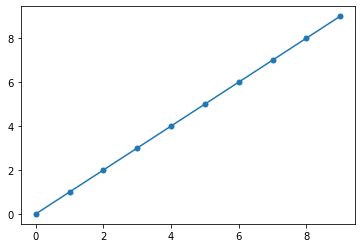

In [19]:
total_loss=[]
total_acc=[]
x_warm=np.arange(0,10)
y_warm=np.arange(0,10)
plt.plot(x_warm,y_warm,marker='o',markersize=5)
plt.show()

## 定义训练函数

In [20]:

def train_model(mydataloader, mycriterion, myoptimizer, myscheduler, my_num_epochs=25):
    since = time.time()
    epoch_loss_x=np.arange(0,my_num_epochs)
    epoch_loss_y=np.zeros(my_num_epochs)
    
    epoch_acc_x=np.arange(0,my_num_epochs)
    epoch_acc_y=np.zeros(my_num_epochs)
    
    for epoch_i in range(0,my_num_epochs):
        # Each epoch has a training and validation phase
        myscheduler.step()
        # Set model to training mode
        model.train(True)  

        running_loss = 0.0
        running_corrects_num = 0.0
        # Iterate over data.
        for data in mydataloader:
            # get the inputs
            inputs, labels = data
            now_batch_size, c, h, w = inputs.shape
            if now_batch_size < train_batch_size:  # skip the last batch
#                 print('continue')
                continue
            inputs = Variable(inputs.cuda().detach())
            labels = Variable(labels.cuda().detach())
            
            # zero the parameter gradients
            myoptimizer.zero_grad()

            # forward
            outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = mycriterion(outputs, labels)


            # statistics
            running_loss += loss.item()
            running_corrects_num += float(torch.sum(preds == labels.data))
            
            # backward + optimize only if in training phase
            loss.backward()
            myoptimizer.step()
            
#             print('train once:')
#             print('once loss:',running_loss)
#             print('once acc:',float(running_corrects_num),'%')
#             print('preds',preds)
#             print('labels',labels)

        print("epoch i=",epoch_i)
        print('loss:',running_loss)
        epoch_loss_y[epoch_i]=running_loss
        print('acc:',running_corrects_num/len(qmdatasets.imgs))
        epoch_acc_y[epoch_i]=running_corrects_num/len(qmdatasets.imgs)
        total_loss.append(running_loss)
        total_acc.append(running_corrects_num/len(qmdatasets.imgs))
        plt.plot(epoch_loss_x,epoch_loss_y,marker='o')
        plt.show()
        plt.plot(epoch_acc_x,epoch_acc_y,marker='o')
        plt.show()
        clear()

## 开始训练

epoch i= 79
loss: 3.1167030623182654
acc: 0.9979482970865818


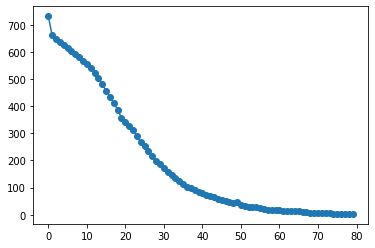

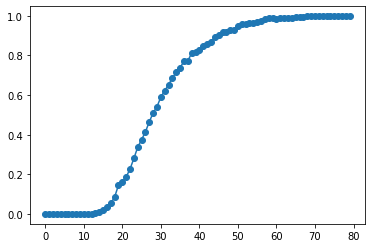

In [21]:
train_model(qmdataloader,criterion,optimizer,exp_lr_scheduler,80)

epoch i= 39
loss: 1.5720447064377367
acc: 0.9979482970865818


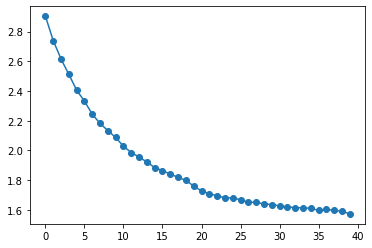

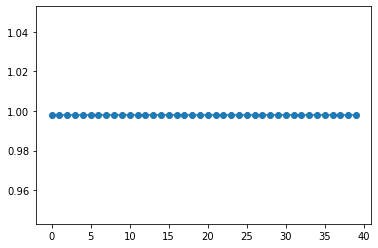

In [22]:
train_model(qmdataloader,criterion,optimizer,exp_lr_scheduler,40)

epoch i= 39
loss: 1.4940271484665573
acc: 0.9979482970865818


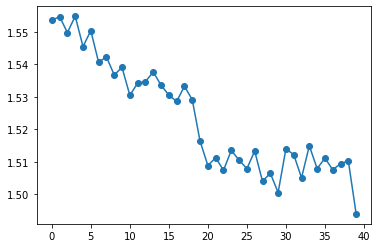

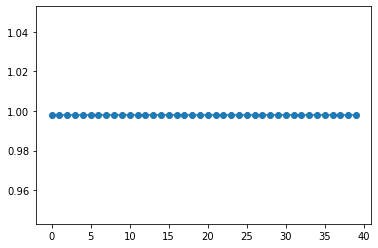

In [23]:
train_model(qmdataloader,criterion,optimizer,exp_lr_scheduler,40)

## 训练结果

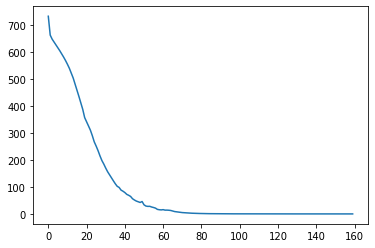

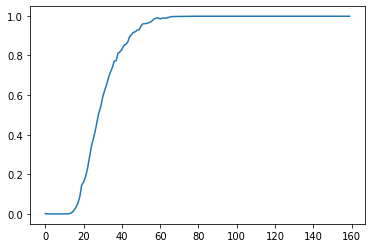

In [24]:
total_x=np.arange(0,len(total_acc))
plt.plot(total_x,total_loss)
plt.show()
plt.plot(total_x,total_acc)
plt.show()

# 评估

751
torch.Size([3, 100, 100])
0
0


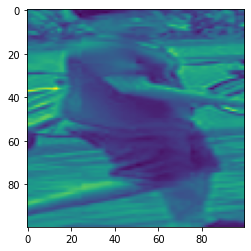

num= 3
row= 1


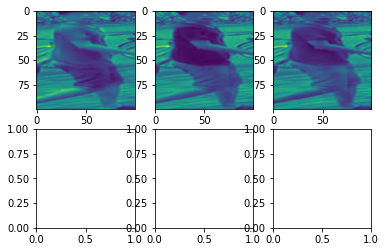

In [25]:
qmdatasets_val= datasets.ImageFolder(
    root=os.path.join('./market1501', 'val'),
    transform=qmtransform,
)
print(len(qmdatasets_val.imgs))
# print(qmdatasets.imgs)
qmdataloader_val=DataLoader(dataset=qmdatasets_val,batch_size=val_batch_size,shuffle=False, num_workers=0, pin_memory=True)
flag=0
num=1
for a,b in enumerate(qmdatasets_val):
    print(b[0].shape)
    print(b[1])
    print(b[1])
    #
    show_onetensor(b[0][0])
    show_batchtesnor(b[0])
    
    flag=flag+1
    if(flag==num):
        break

In [26]:
def val_model(mydataloader, mycriterion, my_num_epochs=1):
    since = time.time()
    for epoch in range(my_num_epochs):
        model.train(False)  

        running_loss = 0.0
        running_corrects_num = 0.0
        # Iterate over data.
        for data in mydataloader:
            # get the inputs
            inputs, labels = data
            now_batch_size, c, h, w = inputs.shape

            inputs = Variable(inputs.cuda().detach())
            labels = Variable(labels.cuda().detach())


            # forward
            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = mycriterion(outputs, labels)


            # statistics
            running_loss += loss.item()
            running_corrects_num += float(torch.sum(preds == labels.data))
            
#             print('train once:')
#             print('once loss:',running_loss)
#             print('once acc:',float(running_corrects_num),'%')
#             print('preds',preds)
#             print('labels',labels)

            
        print('loss:',running_loss)
        print('acc:',running_corrects_num/len(qmdatasets_val.imgs))
#         print("-"*100)
        clear()

In [27]:
val_model(qmdataloader_val,criterion)

loss: 75.92598104476929
acc: 0.3262316910785619


# 保存模型

In [29]:
torch.save(model.state_dict(),'./resnet18_pred_dict_baseline.pth')
torch.save(model,'./resnet18_pred_all_baseline.pth')